In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])

print(u'всего сайтов:', sites_dict_df.shape[0])

sites_dict_df.head()

(u'\u0432\u0441\u0435\u0433\u043e \u0441\u0430\u0439\u0442\u043e\u0432:', 48371)


,site
13852,i1-js-14-3-01-11544-644949368-i.init.cedexis-r...
6240,static.vol24.fr
39840,mars.nasa.gov
3899,scholar.google.fr
9677,9zouxfza1h.s.ad6media.fr


In [4]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [5]:
sites = ['site%d' % i for i in range(1, 11)]

In [6]:
full_sites = full_df[sites]

In [7]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

In [8]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [11]:
X_test_sparse.shape

(82797, 48371)

In [70]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [71]:
def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9, seed=17):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
 #   train_len = int(ratio * X.shape[0])
 #   X_train = X[:train_len, :]
 #   X_valid = X[train_len:, :]
 #   y_train = y[:train_len]
#    y_valid = y[train_len:]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1-ratio,random_state=seed)
    logit = LogisticRegression(C=C, n_jobs=-1, random_state=seed)
    
    logit.fit(X_train, y_train)
    
    valid_pred = logit.predict_proba(X_valid)[:, 1]
    
    return roc_auc_score(y_valid, valid_pred)

In [13]:
get_auc_lr_valid(X_train_sparse, y_train, ratio = 0.9)

0.91952836961654172

In [14]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [15]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index)

In [16]:
new_feat_train['months_count'] = train_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)
new_feat_test['months_count'] = test_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)

In [17]:
scaler = StandardScaler()
scaler.fit(new_feat_train['months_count'].values.reshape(-1, 1))

new_feat_train['months_count_scaled'] = scaler.transform(new_feat_train['months_count'].values.reshape(-1, 1))
scaler = StandardScaler()
scaler.fit(new_feat_test['months_count'].values.reshape(-1, 1))
new_feat_test['months_count_scaled'] = scaler.transform(new_feat_test['months_count'].values.reshape(-1, 1))

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [18]:
X_train_sparse_new = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['months_count_scaled'].values.reshape(-1, 1)]))
X_test_sparse_new = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['months_count_scaled'].values.reshape(-1, 1)]))

In [83]:
get_auc_lr_valid(X_train_sparse_new, y_train)

0.96533431353863197

In [20]:
X_train_sparse_not_scaled_month = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['months_count'].values.reshape(-1, 1)]))
X_test_sparse_not_scaled_month = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['months_count'].values.reshape(-1, 1)]))

In [84]:
get_auc_lr_valid(X_train_sparse_not_scaled_month, y_train)

0.63925076430181671

In [85]:
get_auc_lr_valid(X_train_sparse, y_train)

0.96433761440091936

In [23]:
new_feat_train['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
new_feat_test['start_hour'] = test_df['time1'].apply(lambda ts: ts.hour)

In [24]:
X_train_sparse_start_hour = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['start_hour'].values.reshape(-1, 1)]))
X_test_sparse_start_hour = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['start_hour'].values.reshape(-1, 1)]))

In [86]:
get_auc_lr_valid(X_train_sparse_start_hour, y_train)

0.97609615087900814

In [26]:
new_feat_train['start_hour_x'] = train_df['time1'].apply(lambda ts: np.sin(2*np.pi/24*ts.hour))
new_feat_train['start_hour_y'] = train_df['time1'].apply(lambda ts: np.cos(2*np.pi/24*ts.hour))

new_feat_test['start_hour_x'] = test_df['time1'].apply(lambda ts: np.sin(2*np.pi/24*ts.hour))
new_feat_test['start_hour_y'] = test_df['time1'].apply(lambda ts: np.cos(2*np.pi/24*ts.hour))

In [27]:
X_train_sparse_start_hour_xy = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['start_hour_x'].values.reshape(-1, 1),
                             new_feat_train['start_hour_y'].values.reshape(-1, 1)]))
X_test_sparse_start_hour_xy = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['start_hour_x'].values.reshape(-1, 1),
                             new_feat_test['start_hour_y'].values.reshape(-1, 1)]))

In [28]:
get_auc_lr_valid(X_train_sparse_start_hour_xy, y_train)

0.96445155838462726

In [36]:
new_feat_train['morning'] = train_df['time1'].apply(lambda ts: 1 if ts.hour <= 9 else 0)
new_feat_test['morning'] = test_df['time1'].apply(lambda ts: 1 if ts.hour <= 9 else 0)

In [37]:
X_train_sparse_start_hour_xy_morning = csr_matrix(hstack([X_train_sparse_start_hour_xy, 
                             new_feat_train['morning'].values.reshape(-1, 1)]))
X_test_sparse_start_hour_xy_morning = csr_matrix(hstack([X_test_sparse_start_hour_xy, 
                             new_feat_test['morning'].values.reshape(-1, 1)]))

In [38]:
get_auc_lr_valid(X_train_sparse_start_hour_xy_morning, y_train)

0.96445155838462726

In [39]:
from tqdm import trange

c_test = np.logspace(-3, 1, 10)
scores = []

for idx in trange(len(c_test)):
    rocauc = get_auc_lr_valid(X_train_sparse_start_hour_xy, y_train, C = c_test[idx])
    scores.append(rocauc)
    
max(scores)

100%|██████████████████████████████████████████| 10/10 [01:23<00:00,  8.33s/it]


0.97015684985188433

In [40]:
c_test[np.argmax(scores)]

0.059948425031894091

In [41]:
logit = LogisticRegression(C = 0.059948425031894091, n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_hour_xy, y_train)

LogisticRegression(C=0.0599484250319, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [42]:
test_pred = logit.predict_proba(X_test_sparse_start_hour_xy)[:, 1]

In [43]:
write_to_submission_file(test_pred, 'alice_hour_xy-C-0.059948425031894091.csv')

In [44]:
X_train_sparse_start_hour_xy.shape

(253561, 48373)

In [46]:
X_test_sparse_start_hour_xy.shape

(82797, 48373)

In [47]:
X_train_sparse_start_hour_x = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['start_hour_x'].values.reshape(-1, 1)]))
X_test_sparse_start_hour_x = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['start_hour_x'].values.reshape(-1, 1)]))

In [48]:
get_auc_lr_valid(X_train_sparse_start_hour_x, y_train)

0.96447827717255441

In [49]:
X_train_sparse_start_hour_y = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['start_hour_y'].values.reshape(-1, 1)]))
X_test_sparse_start_hour_y = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['start_hour_y'].values.reshape(-1, 1)]))

In [50]:
get_auc_lr_valid(X_train_sparse_start_hour_y, y_train)

0.93791768862256653

In [75]:
get_auc_lr_valid(X_train_sparse_start_hour_xy, y_train)

0.97754778326292469

In [51]:
from tqdm import trange

c_test = np.logspace(-3, 1, 10)
scores = []

for idx in trange(len(c_test)):
    rocauc = get_auc_lr_valid(X_train_sparse_start_hour_x, y_train, C = c_test[idx])
    scores.append(rocauc)
    
max(scores)

100%|██████████████████████████████████████████| 10/10 [01:22<00:00,  8.29s/it]


0.96993494805384572

In [52]:
c_test[np.argmax(scores)]

0.059948425031894091

In [53]:
logit = LogisticRegression(C = 0.059948425031894091, n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_hour_x, y_train)

LogisticRegression(C=0.0599484250319, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [55]:
test_pred = logit.predict_proba(X_test_sparse_start_hour_x)[:, 1]

In [56]:
write_to_submission_file(test_pred, 'alice_hour_x-C-0.059948425031894091.csv')

In [61]:
params = {'C': np.logspace(-3, 1, 10)}
grid = GridSearchCV(logit,params,
cv=5, n_jobs=-1,
verbose=True)

In [63]:
grid.fit(X_train_sparse_start_hour_x, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=0.0599484250319, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-03,   2.78256e-03,   7.74264e-03,   2.15443e-02,
         5.99484e-02,   1.66810e-01,   4.64159e-01,   1.29155e+00,
         3.59381e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [64]:

grid.grid_scores_

C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.99094, std: 0.00001, params: {'C': 0.001},
 mean: 0.99093, std: 0.00003, params: {'C': 0.0027825594022071257},
 mean: 0.99089, std: 0.00006, params: {'C': 0.0077426368268112694},
 mean: 0.99101, std: 0.00031, params: {'C': 0.021544346900318832},
 mean: 0.99100, std: 0.00059, params: {'C': 0.059948425031894091},
 mean: 0.99100, std: 0.00065, params: {'C': 0.1668100537200059},
 mean: 0.99092, std: 0.00083, params: {'C': 0.46415888336127775},
 mean: 0.99081, std: 0.00096, params: {'C': 1.2915496650148828},
 mean: 0.99059, std: 0.00107, params: {'C': 3.5938136638046259},
 mean: 0.99028, std: 0.00118, params: {'C': 10.0}]

In [65]:
grid.best_params_

{'C': 0.021544346900318832}

In [66]:
best_predict= grid.predict(X_train_sparse_start_hour_x)

In [67]:
best_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(y_train, best_predict)

0.99132753065337331

In [ ]:
train_df['target']

In [76]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [77]:
train_df['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)

In [209]:
train_df['start_total_minutes'] = train_df['time1'].apply(lambda ts: ts.hour*60+ts.minute)

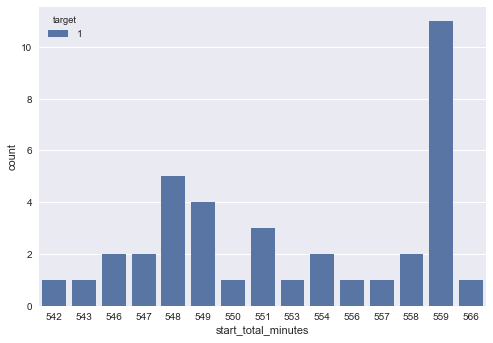

In [250]:
sns.countplot(x="start_total_minutes", hue="target", data=train_df[(train_df['target']==1) & (train_df['start_total_minutes']>=9*60+0) & (train_df['start_total_minutes']<9*60+27)])

In [232]:
new_feat_train['alice_tminutes'] = train_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) else 0)
new_feat_test['alice_tminutes'] = test_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) else 0)


In [257]:
new_feat_train['alice_tminutes2'] = train_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) or (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)
new_feat_test['alice_tminutes2'] = test_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) or (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)


In [258]:
X_train_sparse_alicemin2 = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['alice_tminutes2'].values.reshape(-1, 1)]))
X_test_sparse_alicemin2  = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['alice_tminutes2'].values.reshape(-1, 1)]))

In [259]:
get_auc_lr_valid(X_train_sparse_alicemin2, y_train)

0.98708576028395223

In [262]:
X_train_sparse_start_aliceminutes2_alicem6569 = csr_matrix(hstack([X_train_sparse_alicemin2, 
                             new_feat_train['alice_month_24165'].values.reshape(-1, 1),
                            new_feat_train['alice_month_24167'].values.reshape(-1, 1),
                            new_feat_train['alice_month_24169'].values.reshape(-1, 1)]
                                                      ))
X_test_sparse_start_aliceminutes2_alicem6569  = csr_matrix(hstack([X_test_sparse_alicemin2, 
                              new_feat_test['alice_month_24165'].values.reshape(-1, 1),
                            new_feat_test['alice_month_24167'].values.reshape(-1, 1),
                            new_feat_test['alice_month_24169'].values.reshape(-1, 1)]
                                                      ))

In [263]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes2_alicem6569, y_train)

0.98974362465118593

In [267]:
c_test = np.array([  0.85,0.9,0.95,0.99])
scores = []

for idx in trange(len(c_test)):
    rocauc = get_auc_lr_valid(X_train_sparse_start_aliceminutes2_alicem6569, y_train, C = c_test[idx])
    scores.append(rocauc)
    
max(scores)

100%|████████████████████████████████████████████| 4/4 [00:50<00:00, 12.70s/it]


0.98975078070838685

In [268]:
c_test[np.argmax(scores)]

0.94999999999999996

In [269]:
logit = LogisticRegression(C=0.95,n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceminutes2_alicem6569, y_train)

LogisticRegression(C=0.95, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [270]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceminutes2_alicem6569)[:, 1]
write_to_submission_file(test_pred, 'alice_X_train_sparse_start_aliceminutes2_alicem656769_095.csv')

In [280]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes2_alicem6569, y_train, ratio=0.1)

0.97254111971539692

In [285]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem, y_train, ratio=0.7)

0.98806320368004741

In [283]:
new_feat_train['alice_morning_minutes'] = train_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)
new_feat_test['alice_morning_minutes'] = test_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)


In [284]:
X_train_sparse_start_aliceminutes_alicem_morningMinutes = csr_matrix(hstack([X_train_sparse_start_aliceminutes_alicem, 
                             new_feat_train['alice_morning_minutes'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceminutes_alicem_morningMinutes = csr_matrix(hstack([X_test_sparse_start_aliceminutes_alicem, 
                             new_feat_test['alice_morning_minutes'].values.reshape(-1, 1)]))

In [286]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem_morningMinutes, y_train, ratio=0.7)

0.98890120857410135

In [289]:
train_df['weekday'] = train_df['time1'].apply(lambda ts: ts.weekday())

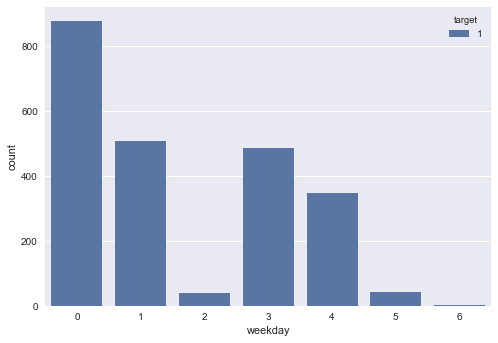

In [290]:
sns.countplot(x="weekday", hue="target", data=train_df[train_df['target']==1])

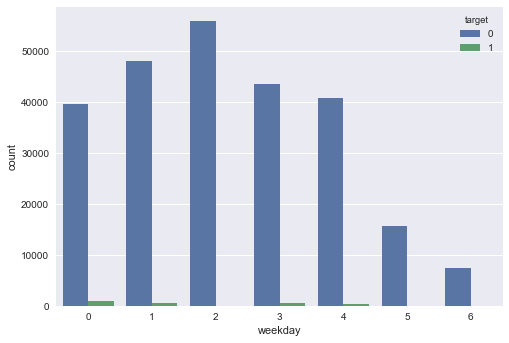

In [291]:
sns.countplot(x="weekday", hue="target", data=train_df)

In [292]:
new_feat_train['day0'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==0 else 0)
new_feat_test['day0'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==0 else 0)

In [293]:
new_feat_train['day2'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==2 else 0)
new_feat_test['day2'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==2 else 0)

In [299]:
new_feat_train['day1'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==1 else 0)
new_feat_test['day1'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==1 else 0)

new_feat_train['day3'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==3 else 0)
new_feat_test['day3'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==3 else 0)

new_feat_train['day4'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==4 else 0)
new_feat_test['day4'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==4 else 0)

new_feat_train['day5'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==5 else 0)
new_feat_test['day5'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==5 else 0)

In [294]:
X_train_sparse_start_aliceminutes_alicem_morningMinutes_day02 = csr_matrix(hstack([X_train_sparse_start_aliceminutes_alicem_morningMinutes, 
                             new_feat_train['day0'].values.reshape(-1, 1),
                            new_feat_train['day2'].values.reshape(-1, 1)]
                                                      ))
X_test_sparse_start_aliceminutes_alicem_morningMinutes_day02 = csr_matrix(hstack([X_test_sparse_start_aliceminutes_alicem_morningMinutes, 
                             new_feat_test['day0'].values.reshape(-1, 1),
                            new_feat_test['day2'].values.reshape(-1, 1)]
                                                      ))

In [298]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem_morningMinutes_day02, y_train, ratio=0.5)

0.98991683213413706

In [296]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceminutes_alicem_morningMinutes_day02, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [297]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceminutes_alicem_morningMinutes_day02)[:, 1]
write_to_submission_file(test_pred, 'alice_X_test_sparse_start_aliceminutes_alicem_morningMinutes_day02.csv')

In [301]:
X_train_sparse_start_aliceminutes_alicem_morningMinutes_dayall = csr_matrix(hstack([X_train_sparse_start_aliceminutes_alicem_morningMinutes_day02, 
                             new_feat_train['day1'].values.reshape(-1, 1),
                            new_feat_train['day3'].values.reshape(-1, 1),
                                                                                   new_feat_train['day4'].values.reshape(-1, 1),
new_feat_train['day5'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_sparse_start_aliceminutes_alicem_morningMinutes_dayall = csr_matrix(hstack([X_test_sparse_start_aliceminutes_alicem_morningMinutes_day02, 
                             new_feat_test['day1'].values.reshape(-1, 1),
                            new_feat_test['day3'].values.reshape(-1, 1),
                                                                                    new_feat_test['day4'].values.reshape(-1, 1),
                            new_feat_test['day5'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [302]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem_morningMinutes_dayall, y_train, ratio=0.5)

0.98999511840346244

In [308]:
X_train_sparse_start_aliceminutes_alicem_dayall = csr_matrix(hstack([X_train_sparse_start_aliceminutes_alicem, 
                             new_feat_train['day1'].values.reshape(-1, 1),
                            new_feat_train['day3'].values.reshape(-1, 1),
                                                                     new_feat_train['day0'].values.reshape(-1, 1),
                            new_feat_train['day2'].values.reshape(-1, 1),
                                                                                   new_feat_train['day4'].values.reshape(-1, 1),
new_feat_train['day5'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_sparse_start_aliceminutes_alicem_dayall = csr_matrix(hstack([X_test_sparse_start_aliceminutes_alicem, 
                             new_feat_test['day1'].values.reshape(-1, 1),
                            new_feat_test['day3'].values.reshape(-1, 1),
new_feat_test['day0'].values.reshape(-1, 1),
                            new_feat_test['day2'].values.reshape(-1, 1),
                                                                                    new_feat_test['day4'].values.reshape(-1, 1),
                            new_feat_test['day5'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [309]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem_dayall, y_train, ratio=0.9)

0.99212606808517179

In [310]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceminutes_alicem_dayall, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [311]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceminutes_alicem_dayall)[:, 1]
write_to_submission_file(test_pred, 'alice_X_train_sparse_start_aliceminutes_alicem_dayall.csv')

In [233]:
X_train_sparse_alicemin = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['alice_tminutes'].values.reshape(-1, 1)]))
X_test_sparse_alicemin  = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['alice_tminutes'].values.reshape(-1, 1)]))

In [235]:
get_auc_lr_valid(X_train_sparse_alicemin, y_train)

0.98650035989731588

In [236]:
X_train_sparse_start_aliceminutes_alicem = csr_matrix(hstack([X_train_sparse_alicemin, 
                             new_feat_train['alice_month_24165'].values.reshape(-1, 1),
                            new_feat_train['alice_month_24167'].values.reshape(-1, 1),
                            new_feat_train['alice_month_24169'].values.reshape(-1, 1)]
                                                      ))
X_test_sparse_start_aliceminutes_alicem  = csr_matrix(hstack([X_test_sparse_alicemin, 
                              new_feat_test['alice_month_24165'].values.reshape(-1, 1),
                            new_feat_test['alice_month_24167'].values.reshape(-1, 1),
                            new_feat_test['alice_month_24169'].values.reshape(-1, 1)]
                                                      ))

In [237]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem, y_train)

0.98898612981576473

In [245]:

c_test = np.logspace(-2, 2, 10)
scores = []

for idx in trange(len(c_test)):
    rocauc = get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem, y_train, C = c_test[idx])
    scores.append(rocauc)
    
max(scores)

100%|██████████████████████████████████████████| 10/10 [04:50<00:00, 29.01s/it]


0.98897530846097292

In [244]:
c_test

array([  1.00000000e-02,   2.78255940e-02,   7.74263683e-02,
         2.15443469e-01,   5.99484250e-01,   1.66810054e+00,
         4.64158883e+00,   1.29154967e+01,   3.59381366e+01,
         1.00000000e+02])

In [243]:
c_test = np.logspace(-2, 2, 10)

In [241]:
c_test[np.argmax(scores)]

1.2915496650148828

In [246]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceminutes_alicem, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [247]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceminutes_alicem)[:, 1]
write_to_submission_file(test_pred, 'alice_X_test_sparse_start_aliceminutes_alicem.csv')

In [238]:
X_train_sparse_start_aliceminutes_alicem_smonth = csr_matrix(hstack([X_train_sparse_start_aliceminutes_alicem, 
                             new_feat_train['months_count_scaled'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceminutes_alicem_smonth  = csr_matrix(hstack([X_test_sparse_start_aliceminutes_alicem, 
                             new_feat_test['months_count_scaled'].values.reshape(-1, 1)]))

In [239]:
get_auc_lr_valid(X_train_sparse_start_aliceminutes_alicem_smonth, y_train)

0.98890514419280717

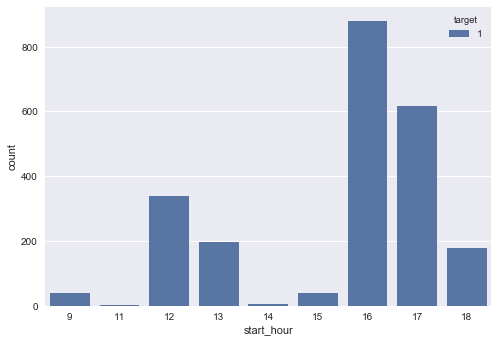

In [78]:
sns.countplot(x="start_hour", hue="target", data=train_df[train_df['target']==1])

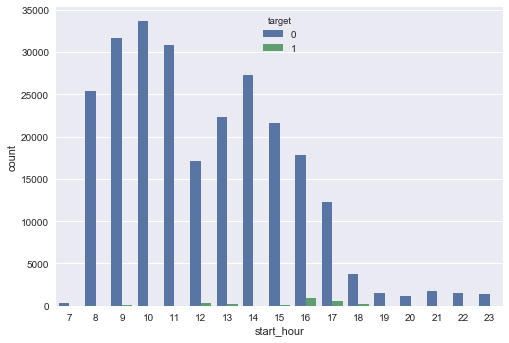

In [79]:
sns.countplot(x="start_hour", hue="target", data=train_df)

In [87]:
get_auc_lr_valid(X_train_sparse_start_hour_x, y_train)

0.97755633562396982

In [89]:
new_feat_train['alice_hours'] = train_df['time1'].apply(lambda ts: 1 if ts.hour >= 12 and ts.hour <=18 else 0)
new_feat_test['alice_hours'] = test_df['time1'].apply(lambda ts: 1 if  ts.hour >= 12 and ts.hour <=18 else 0)

In [90]:
X_train_sparse_start_hour_x_aliceh = csr_matrix(hstack([X_train_sparse_start_hour_x, 
                             new_feat_train['alice_hours'].values.reshape(-1, 1)]))
X_test_sparse_start_hour_x_aliceh  = csr_matrix(hstack([X_test_sparse_start_hour_x, 
                             new_feat_test['alice_hours'].values.reshape(-1, 1)]))

In [91]:
get_auc_lr_valid(X_train_sparse_start_hour_x_aliceh, y_train)

0.97987193101141967

In [179]:
new_feat_train['alice_hours2'] = train_df['time1'].apply(lambda ts: 1 if ts.hour in [12,13,16,17,18] else 0)
new_feat_test['alice_hours2'] = test_df['time1'].apply(lambda ts: 1 if  ts.hour in [12,13,16,17,18]  else 0)

In [180]:
X_train_sparse_start_hour_x_aliceh2 = csr_matrix(hstack([X_train_sparse_start_hour_x, 
                             new_feat_train['alice_hours2'].values.reshape(-1, 1)]))
X_test_sparse_start_hour_x_aliceh2  = csr_matrix(hstack([X_test_sparse_start_hour_x, 
                             new_feat_test['alice_hours2'].values.reshape(-1, 1)]))

In [181]:
get_auc_lr_valid(X_train_sparse_start_hour_x_aliceh2, y_train)

0.98698662271102167

In [182]:
X_train_sparse_start_aliceh2 = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['alice_hours2'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceh2  = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['alice_hours2'].values.reshape(-1, 1)]))

In [183]:
get_auc_lr_valid(X_train_sparse_start_aliceh2, y_train)

0.98601723876725922

In [186]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceh2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [187]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceh2)[:, 1]
write_to_submission_file(test_pred, 'alice_X_test_sparse_start_aliceh2.csv')

In [92]:
X_train_sparse_start_aliceh = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['alice_hours'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceh  = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['alice_hours'].values.reshape(-1, 1)]))

In [93]:
get_auc_lr_valid(X_train_sparse_start_aliceh, y_train)

0.9790629474717476

In [94]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_hour_x_aliceh, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
test_pred = logit.predict_proba(X_test_sparse_start_hour_x_aliceh)[:, 1]
write_to_submission_file(test_pred, 'alice_X_test_sparse_start_hour_x_aliceh.csv')

In [96]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceh, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceh)[:, 1]
write_to_submission_file(test_pred, 'alice_X_test_sparse_aliceh.csv')

In [99]:
new_feat_train['months_count'] = train_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)
new_feat_test['months_count'] = test_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)

In [195]:
train_df['months_count'] = train_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)

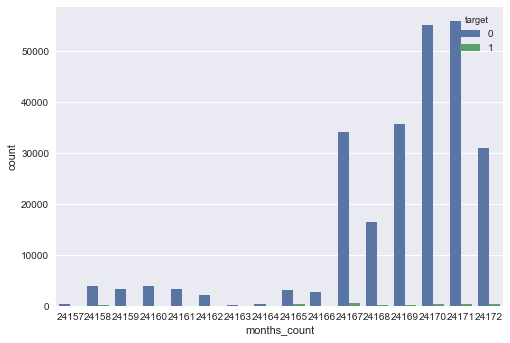

In [102]:
sns.countplot(x="months_count", hue="target", data=train_df)

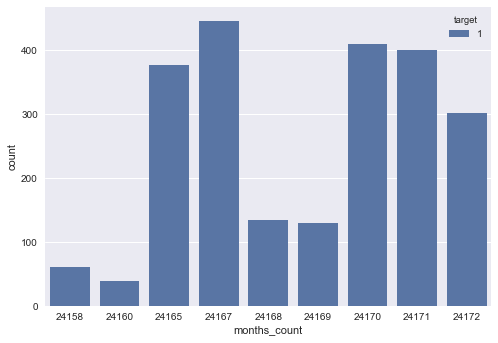

In [103]:
sns.countplot(x="months_count", hue="target",data=train_df[train_df['target']==1])

In [104]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time7,site8,time8,site9,time9,site10,time10,target,start_hour,months_count
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,8,24157
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,8,24157
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,8,24157
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,8,24157
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,8,24157


In [105]:
scaler = StandardScaler()
scaler.fit(new_feat_train['months_count'].values.reshape(-1, 1))

new_feat_train['months_count_scaled'] = scaler.transform(new_feat_train['months_count'].values.reshape(-1, 1))
new_feat_test['months_count_scaled'] = scaler.transform(new_feat_test['months_count'].values.reshape(-1, 1))

In [106]:
X_train_sparse_start_aliceh_smonth = csr_matrix(hstack([X_train_sparse_start_aliceh, 
                             new_feat_train['months_count_scaled'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceh_smonth  = csr_matrix(hstack([X_test_sparse_start_aliceh, 
                             new_feat_test['months_count_scaled'].values.reshape(-1, 1)]))

In [107]:
get_auc_lr_valid(X_train_sparse_start_aliceh_smonth, y_train)

0.98002866611791917

In [184]:
X_train_sparse_start_aliceh2_smonth = csr_matrix(hstack([X_train_sparse_start_aliceh2, 
                             new_feat_train['months_count_scaled'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceh2_smonth  = csr_matrix(hstack([X_test_sparse_start_aliceh2, 
                             new_feat_test['months_count_scaled'].values.reshape(-1, 1)]))

In [185]:
get_auc_lr_valid(X_train_sparse_start_aliceh2_smonth, y_train)

0.98672795742390318

In [198]:
new_feat_train['alice_month_24165'] = train_df['months_count'].apply(lambda ts:ts==24165)
new_feat_test['alice_month_24165'] = test_df['months_count'].apply(lambda ts:ts==24165)

In [199]:
new_feat_train['alice_month_24167'] = train_df['months_count'].apply(lambda ts:ts==24167)
new_feat_test['alice_month_24167'] = test_df['months_count'].apply(lambda ts:ts==24167)

In [200]:
new_feat_train['alice_month_24169'] = train_df['months_count'].apply(lambda ts:ts==24169)
new_feat_test['alice_month_24169'] = test_df['months_count'].apply(lambda ts:ts==24169)

In [202]:
X_train_sparse_start_aliceh_alicem = csr_matrix(hstack([X_train_sparse_start_aliceh2, 
                             new_feat_train['alice_month_24165'].values.reshape(-1, 1),
                            new_feat_train['alice_month_24167'].values.reshape(-1, 1),
                            new_feat_train['alice_month_24169'].values.reshape(-1, 1)]
                                                      ))
X_test_sparse_start_aliceh_alicem  = csr_matrix(hstack([X_test_sparse_start_aliceh2, 
                              new_feat_test['alice_month_24165'].values.reshape(-1, 1),
                            new_feat_test['alice_month_24167'].values.reshape(-1, 1),
                            new_feat_test['alice_month_24169'].values.reshape(-1, 1)]
                                                      ))

In [203]:
get_auc_lr_valid(X_train_sparse_start_aliceh_alicem, y_train)

0.98857352202983484

In [206]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_start_aliceh_alicem, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [207]:
test_pred = logit.predict_proba(X_test_sparse_start_aliceh_alicem)[:, 1]
write_to_submission_file(test_pred, 'alice_X_test_sparse_start_aliceh_alicem.csv')

In [204]:
X_train_sparse_start_aliceh_alicem_smonth = csr_matrix(hstack([X_train_sparse_start_aliceh_alicem, 
                             new_feat_train['months_count_scaled'].values.reshape(-1, 1)]))
X_test_sparse_start_aliceh_alicem_smonth  = csr_matrix(hstack([X_test_sparse_start_aliceh_alicem, 
                             new_feat_test['months_count_scaled'].values.reshape(-1, 1)]))

In [205]:
get_auc_lr_valid(X_train_sparse_start_aliceh_alicem_smonth, y_train)

0.9884817150520856

In [197]:
new_feat_train.head()

,months_count,months_count_scaled,start_hour,start_hour_x,start_hour_y,morning,alice_hours,alice_hours2,alice_month_24165
session_id,,,,,,,,,
21669,24157,-3.97424,8,0.866025,-0.5,1,0,0,False
54843,24157,-3.97424,8,0.866025,-0.5,1,0,0,False
77292,24157,-3.97424,8,0.866025,-0.5,1,0,0,False
114021,24157,-3.97424,8,0.866025,-0.5,1,0,0,False
146670,24157,-3.97424,8,0.866025,-0.5,1,0,0,False


In [118]:
train_df['sites_count'] = int(train_df['site1']>0)+int(train_df['site2']>0)+int(train_df['site3']>0)+int(train_df['site4']>0)+int(train_df['site5']>0)
+int(train_df['site6']>0)
+int(train_df['site7']>0)
+int(train_df['site8']>0)
+int(train_df['site9']>0)
+int(train_df['site10']>0)

TypeError: cannot convert the series to <type 'int'>

In [124]:
train_df['sites_count'] =  train_df.apply(lambda ts: int(ts['site1']>0)+int(ts['site2']>0)+int(ts['site3']>0)+int(ts['site4']>0)+int(ts['site5']>0)
+int(ts['site6']>0)
+int(ts['site7']>0)
+int(ts['site8']>0)
+int(ts['site9']>0)
+int(ts['site10']>0), axis=1)

In [125]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site8,time8,site9,time9,site10,time10,target,start_hour,months_count,sites_count
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,0,8,24157,2
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,0,8,24157,4
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,8,24157,10
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,8,24157,10
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,8,24157,10


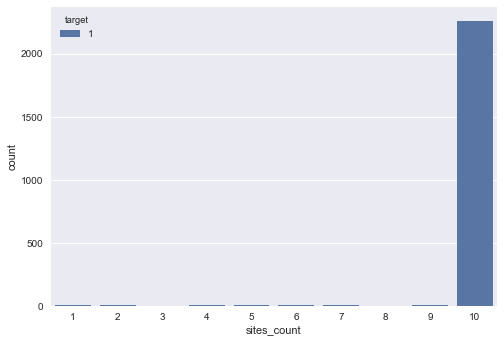

In [126]:
sns.countplot(x="sites_count", hue="target",data=train_df[train_df['target']==1])

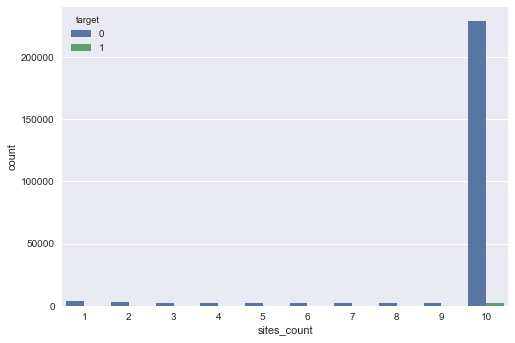

In [127]:
sns.countplot(x="sites_count", hue="target",data=train_df)

,months_count,months_count_scaled,start_hour,start_hour_x,start_hour_y,morning,alice_hours
session_id,,,,,,,
21669,24157,-3.97424,8,0.866025,-0.5,1,0
54843,24157,-3.97424,8,0.866025,-0.5,1,0
77292,24157,-3.97424,8,0.866025,-0.5,1,0
114021,24157,-3.97424,8,0.866025,-0.5,1,0
146670,24157,-3.97424,8,0.866025,-0.5,1,0


In [128]:
new_feat_train['sites_count'] = new_feat_train.apply(lambda ts: int(ts['site1']>0)+int(ts['site2']>0)+int(ts['site3']>0)+int(ts['site4']>0)+int(ts['site5']>0)
+int(ts['site6']>0)
+int(ts['site7']>0)
+int(ts['site8']>0)
+int(ts['site9']>0)
+int(ts['site10']>0), axis=1)
new_feat_test['sites_count'] = new_feat_test.apply(lambda ts: int(ts['site1']>0)+int(ts['site2']>0)+int(ts['site3']>0)+int(ts['site4']>0)+int(ts['site5']>0)
+int(ts['site6']>0)
+int(ts['site7']>0)
+int(ts['site8']>0)
+int(ts['site9']>0)
+int(ts['site10']>0), axis=1)

KeyError: ('site1', u'occurred at index 21669')

In [130]:
X_train_sparse_start_aliceh_smonth_sitescount = csr_matrix(hstack([X_train_sparse_start_aliceh_smonth, 
                             train_df['sites_count'].values.reshape(-1, 1)]))
#X_test_sparse_start_aliceh_smonth_sitescount  = csr_matrix(hstack([X_train_sparse_start_aliceh_smonth, 
 #                            new_feat_test['sites_count'].values.reshape(-1, 1)]))

In [132]:
get_auc_lr_valid(X_train_sparse_start_aliceh_smonth, y_train)

0.98002866611791917

In [133]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site8,time8,site9,time9,site10,time10,target,start_hour,months_count,sites_count
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,NaT,0,8,24157,2
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,NaT,0,8,24157,4
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,8,24157,10
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,8,24157,10
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,8,24157,10


In [147]:
qdf = train_df.head().copy()

In [163]:
qdf['total_minutes']= qdf.apply(lambda ts: round((ts['time10']-ts['time1']).total_seconds()/60), axis=1)


In [164]:
qdf

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site9,time9,site10,time10,target,start_hour,months_count,sites_count,q,total_minutes
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,8,24157,2,NaN,NaN
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,8,24157,4,NaN,NaN
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,8,24157,10,3.0,0.0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,8,24157,10,3.0,0.0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,8,24157,10,2.0,0.0


In [155]:
train_df['total_seconds']= train_df.apply(lambda ts: (ts['time10']-ts['time2']).total_seconds(), axis=1)


Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [156]:
train_df['total_seconds']= train_df.apply(lambda ts: (ts['time10']-ts['time1']).total_seconds(), axis=1)


In [169]:
train_df['total_minutes']= (train_df['total_seconds']/60).apply(lambda x: round(x))


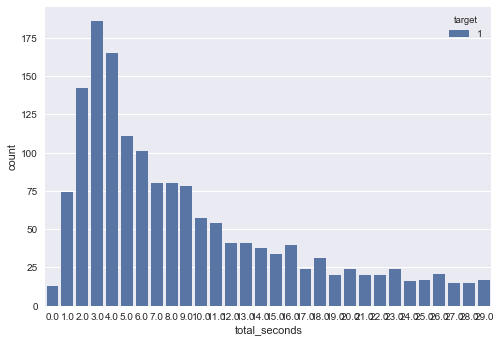

In [176]:
sns.countplot(x="total_seconds", hue="target",data=train_df[(train_df['target']==1) & (train_df['total_seconds']<=30)])

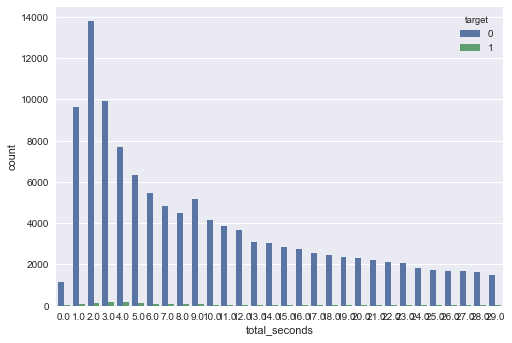

In [177]:
sns.countplot(x="total_seconds", hue="target",data=train_df[(train_df['total_seconds']<=30)])

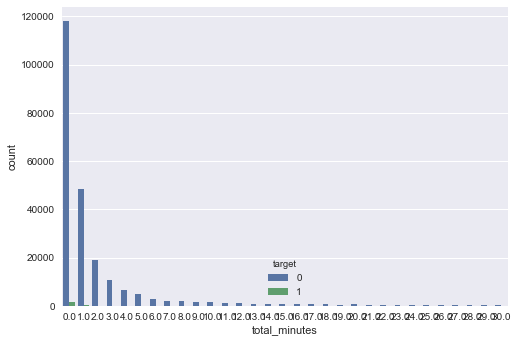

In [178]:
sns.countplot(x="total_minutes", hue="target",data=train_df)